In [1]:
!pip install dgl

In [2]:
import dgl

In [3]:
dataset = dgl.data.CiteseerGraphDataset()
dataset

  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Dataset("citeseer", num_graphs=1, save_path=/root/.dgl/citeseer_d6836239)

In [4]:
graph = dataset[0]
graph

Graph(num_nodes=3327, num_edges=9228,
      ndata_schemes={'feat': Scheme(shape=(3703,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

In [5]:
features = graph.ndata['feat']
labels = graph.ndata['label']

In [6]:
train_mask = graph.ndata['train_mask']
test_mask = graph.ndata['test_mask']

In [7]:
train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [8]:
labels[train_mask]

tensor([3, 1, 5, 5, 3, 1, 3, 0, 3, 5, 2, 4, 2, 1, 2, 3, 2, 4, 4, 0, 1, 5, 5, 3,
        5, 2, 5, 2, 4, 2, 2, 2, 4, 5, 2, 3, 4, 5, 3, 3, 2, 1, 2, 1, 5, 1, 1, 4,
        2, 3, 3, 2, 5, 2, 5, 1, 4, 1, 4, 2, 2, 3, 4, 5, 5, 1, 3, 3, 4, 2, 4, 1,
        1, 5, 0, 2, 0, 3, 5, 2, 4, 1, 1, 4, 4, 0, 4, 4, 5, 3, 5, 5, 4, 5, 3, 1,
        4, 4, 3, 1, 3, 0, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#### GraphConv Layer in dgl
```
dgl.nn.pytorch.conv.GraphConv(in_feats, out_feats,
                                  norm='both', weight=True, bias=True,
                                      activation=None,
                                          allow_zero_in_degree=False)



In [9]:
graph = dgl.remove_self_loop(graph)
graph = dgl.add_self_loop(graph)

In [10]:
feat_in = features.shape[-1]
feat_in

3703

In [11]:
num_class = dataset.num_classes
num_class

6

In [12]:
from dgl.nn import GraphConv
import torch.nn as nn
import torch.nn.functional as func

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GraphConv(feat_in, 64)
        self.layer2 = GraphConv(64, num_class)
        self.dropout = nn.Dropout(0.5)

    def forward(self, g, features):
        h1 = func.relu(self.layer1(g, features))
        h1 = self.dropout(h1)
        h2 = self.layer2(g, h1)
        return h2

net = Net()

In [14]:
import torch

In [15]:
def evaluate(model, g, features, labels, mask):
    model.eval()
    with torch.inference_mode():
        pred = model(g, features)
        pred = pred[mask]
        labels = labels[mask]

        _, indices = torch.max(pred, dim=1)
        correct = torch.sum(indices == labels)

        return correct.item()*1.0/len(labels)

In [16]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, weight_decay=5e-4, eps=1e-8, amsgrad=True)

loss_list =[]
acc_list = []
all_pred = []

EPOCHS = 100
for epoch in range(EPOCHS):
    net.train()
    # forward
    pred = net(graph, features)

    logp = func.log_softmax(pred,1)
    all_pred.append(logp)

    # loss
    loss = func.cross_entropy(logp[train_mask], labels[train_mask])
    loss_list.append(loss.item())
    # BackwardPropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Test
    acc = evaluate(net, graph, features, labels, test_mask)
    acc_list.append(acc)

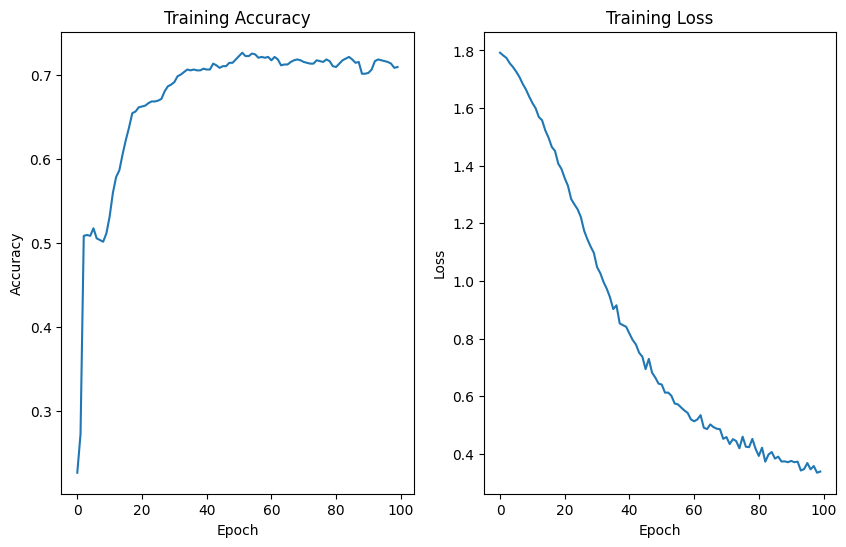

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))

fig.add_subplot(1, 2, 1)
plt.title('Training Accuracy')
plt.plot(acc_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

fig.add_subplot(1, 2, 2)
plt.title('Training Loss')
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()